In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
class RandomWeightedGraph(nx.Graph):
    def __init__(self, nodes:int):
        super().__init__(nx.bipartite.random_graph(nodes, nodes, 0.5).edges())
        for (u, v) in self.edges():
            self.edges[u,v]['weight'] = np.random.randint(10, 100)
            
    def weight(self, edge):
        return self.edges[edge]['weight']

In [3]:
class MinimumSpanningTree(dict):
    def __init__(self, G: nx.Graph, root: int, describe: bool = False):
        self._original_G, self._G, self._root = G.copy(), G, root
        if describe:
            self._setup_describe()

    def _setup_describe(self):
        #self._pos = nx.kamada_kawai_layout(self._G)
        self._pos = nx.spring_layout(self._G, iterations=10000)
        gray, self._dark_gray = '#eeeeee', '#555555'
        self._node_colors = [gray for n in self._G]
        self._edge_colors = [gray for e in self._G.edges]
        positions = np.array(list(self._pos.values()))
        self._min_x, self._min_y = np.min(positions, axis=0) - 0.1
        self._max_x, self._max_y = np.max(positions, axis=0) + 0.1

    def _plot_graphs(self, graphs: list, title: str):
        n, graph_size, graph_per_row = len(graphs), 7, 4
        w, h = min(n, graph_per_row), np.ceil(n / graph_per_row)
        plt.figure(figsize=(graph_size * w, graph_size * h))
        plt.suptitle(title)
        for i, (G, colors, title) in enumerate(graphs):
            ax = plt.subplot(h, w, i + 1)
            ax.set_xlim(self._min_x, self._max_x)
            ax.set_ylim(self._min_y, self._max_y)
            ax.set_title(title)
            nx.draw(
                self._original_G,
                pos=self._pos,
                with_labels=True,
                font_color="#999999",
                edge_labels=nx.get_edge_attributes(self._original_G, 'weight'),
                node_color=self._node_colors,
                edge_color=self._edge_colors)
            nx.draw(
                G,
                pos=self._pos,
                with_labels=True,
                font_color="#222222",
                node_color=colors,
                edge_color=colors)
            nx.draw_networkx_edge_labels(
                self._original_G,
                pos=self._pos,
                font_color="#999999",
                edge_labels=nx.get_edge_attributes(self._original_G, 'weight'))

        legend = {
            "Tree": "r",
            "Unexplored": "c",
            "Current node": "m",
            "Unexplored neighbours": "g"
        }

        plt.margins(0.5, 0.1)
        plt.legend(
            [Line2D([0], [0], color=color, lw=4) for color in legend.values()],
            legend.keys(),
            loc='center right',
            bbox_to_anchor=(2, 0.5))
        plt.show()

    def _describe_start(self, root: int):
        tree = nx.Graph()
        tree.add_node(root)
        colors = ['r' for n in self._original_G]
        self._plot_graphs([(self._original_G, colors, "Initial Graph"),
                           (tree, colors, "Initial Tree")],
                          "Initial Conditions")

In [4]:
class PrimTree(MinimumSpanningTree):
    def __init__(self, G: nx.Graph, root: int, describe: bool = False):
        super().__init__(G, root, describe=describe)

    def run(self):
        self._costs = dict((v, np.inf) if v != root else (v, 0) for v in G)
        self._pred = {root: root}
        while self._costs and not self._is_spanning():
            self.iteration()

    def iteration(self):
        node = min(self._costs, key=self._costs.get)
        self[node] = self._pred[node]
        self._costs.pop(node, None)
        self._neighbors = []
        for v in self._G.neighbors(node):
            if v in self._costs and self._G.weight((node, v)) < self._costs[v]:
                self._pred[v] = node
                self._neighbors.append(v)
                self._costs[v] = self._G.weight((node, v))
        return node

    def _is_spanning(self):
        """Determine if tree is currently spanning the graph G."""
        return len({v for g in zip(*self.items()) for v in g}) == len(self._G)

In [5]:
class GraphicalPrimTree(PrimTree):
    def __init__(self, G: nx.Graph, root: int):
        super().__init__(G, root, describe=True)

    def run(self):
        self._i = 0
        super().run()

    def iteration(self):
        node = super().iteration()
        self._plot_graphs([
            (*self._create_iteration_graph(self._costs, self._neighbors, node),
             "Current step"),
            (nx.Graph(list(self.items())), ['r' for n in self], "Current Tree")
        ], "Iteration {i}: adding node {node}.".format(i=self._i, node=node))
        self._i += 1

    def _create_iteration_graph(self, costs: dict, neighbors: list,
                                node: int) -> tuple:
        iteration = nx.Graph()
        [iteration.add_node(v) for v in [*costs, node, *neighbors]]
        colors = [
            'g' if v in neighbors else 'm' if v == node else 'c'
            for v in iteration
        ]
        return iteration, colors

In [6]:
random.seed(32)
np.random.seed(23)
G = RandomWeightedGraph(6)
root = 1
end = 4

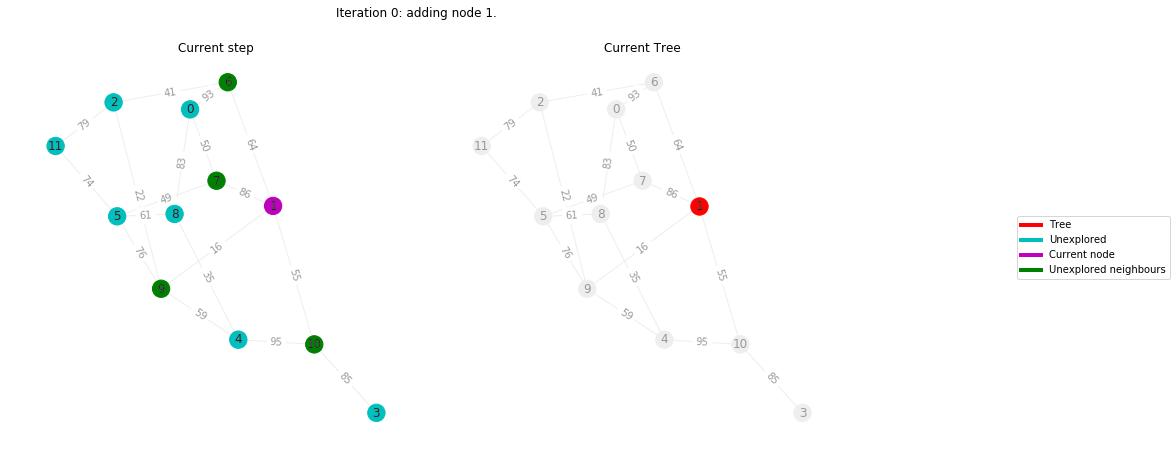

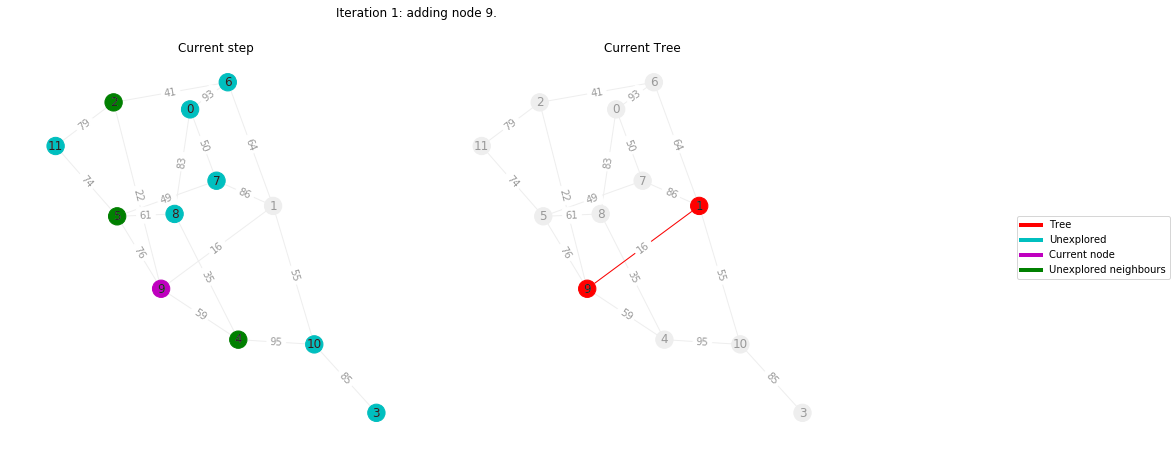

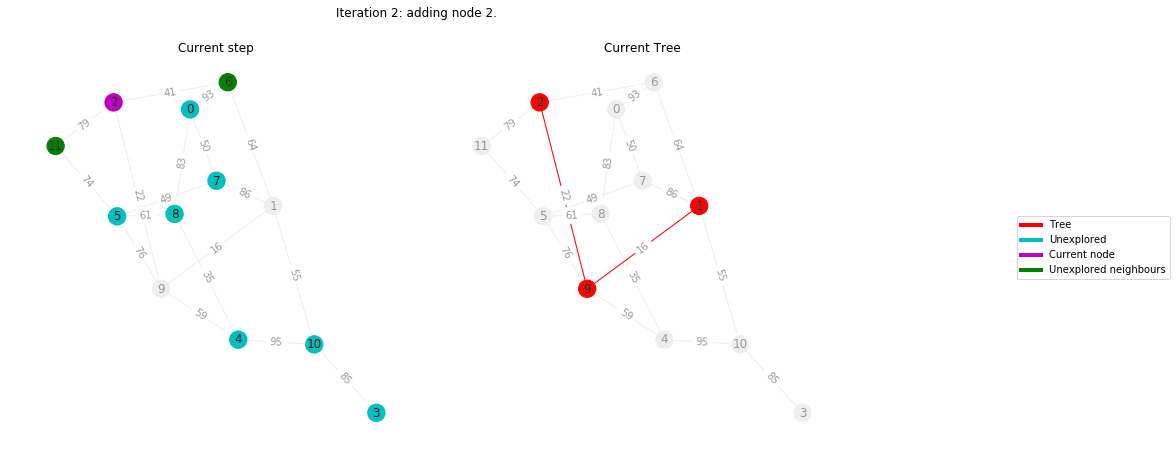

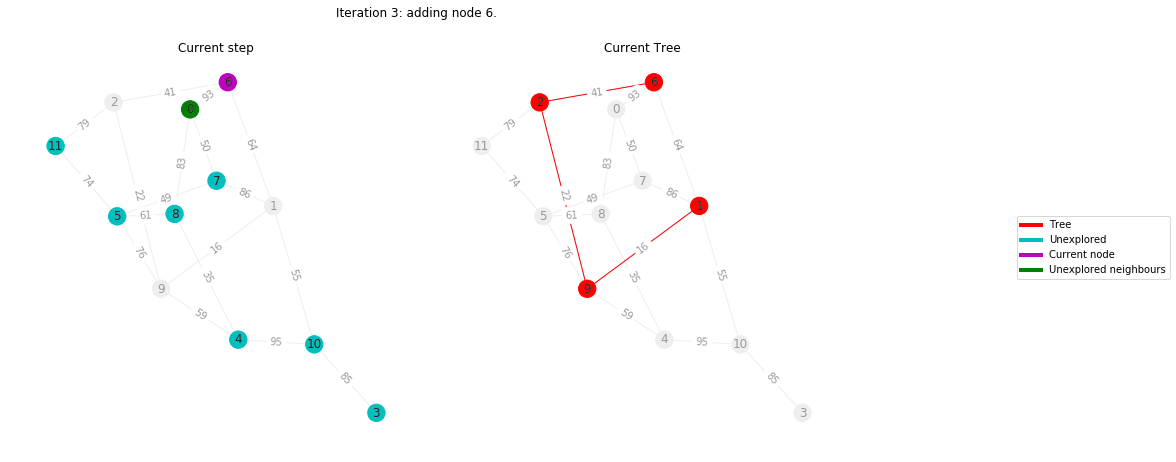

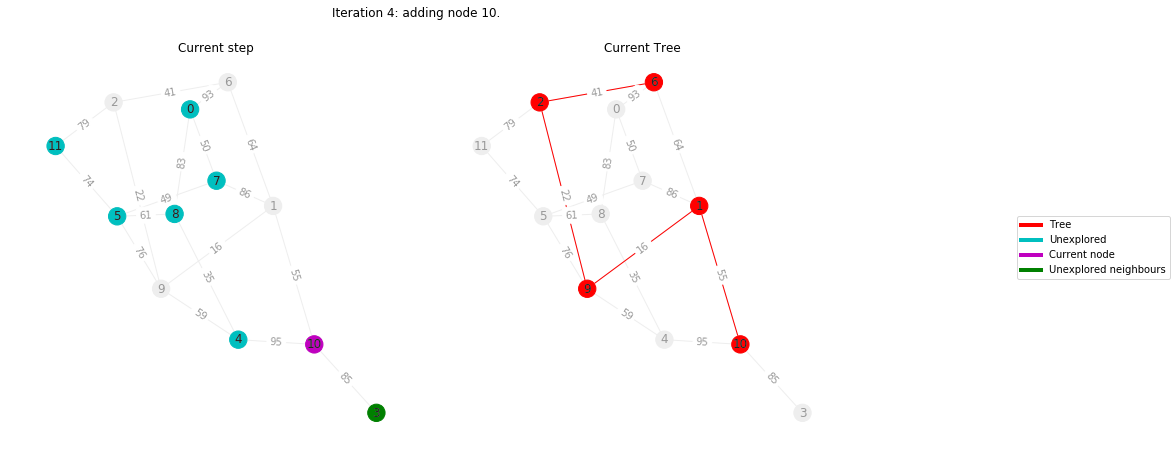

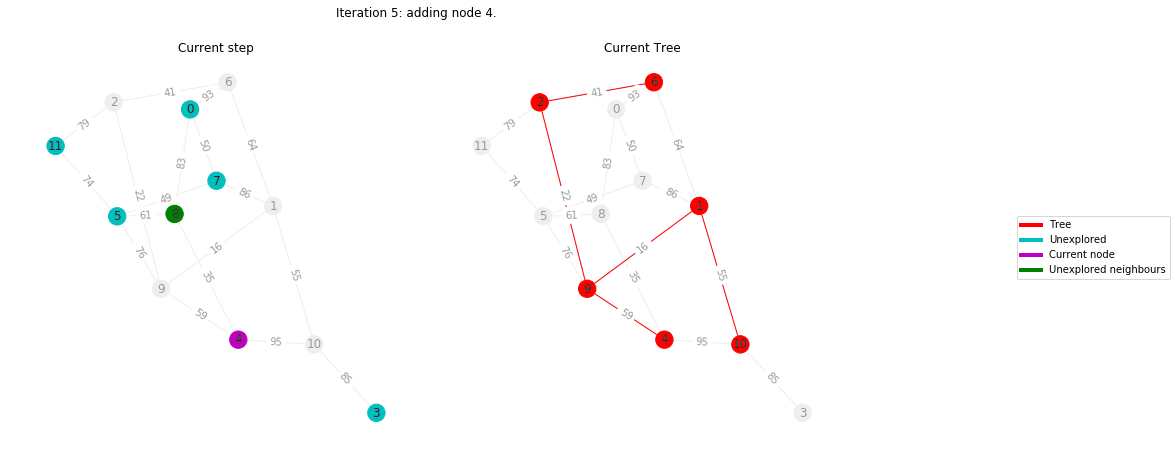

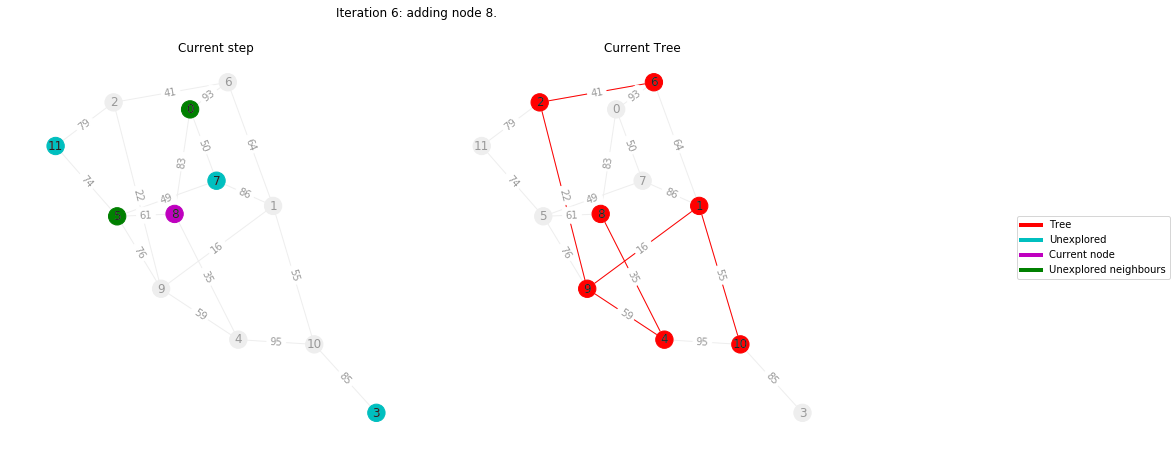

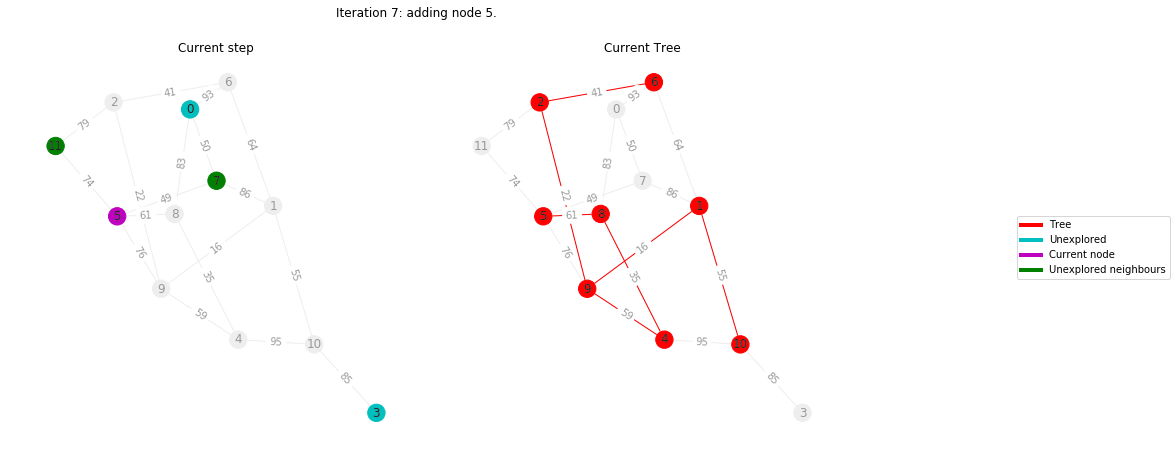

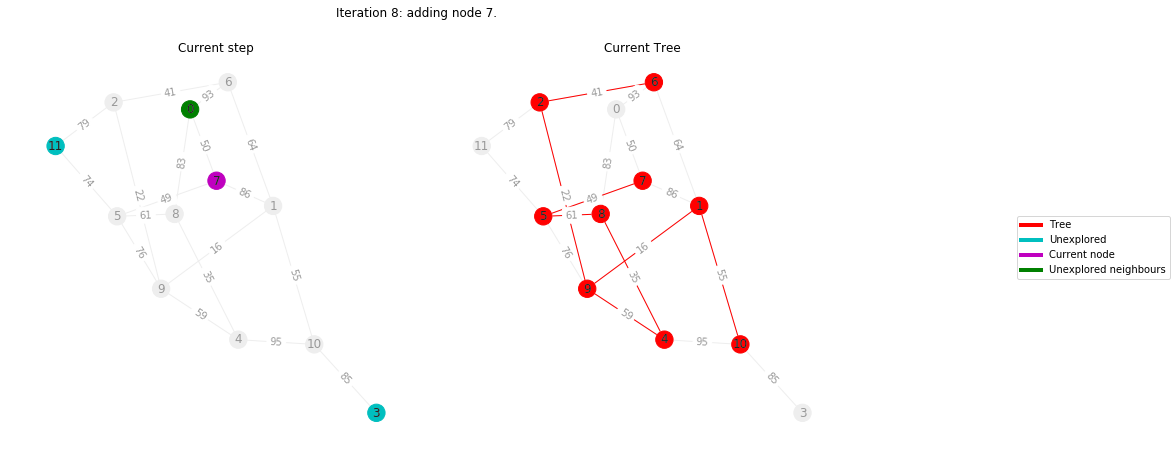

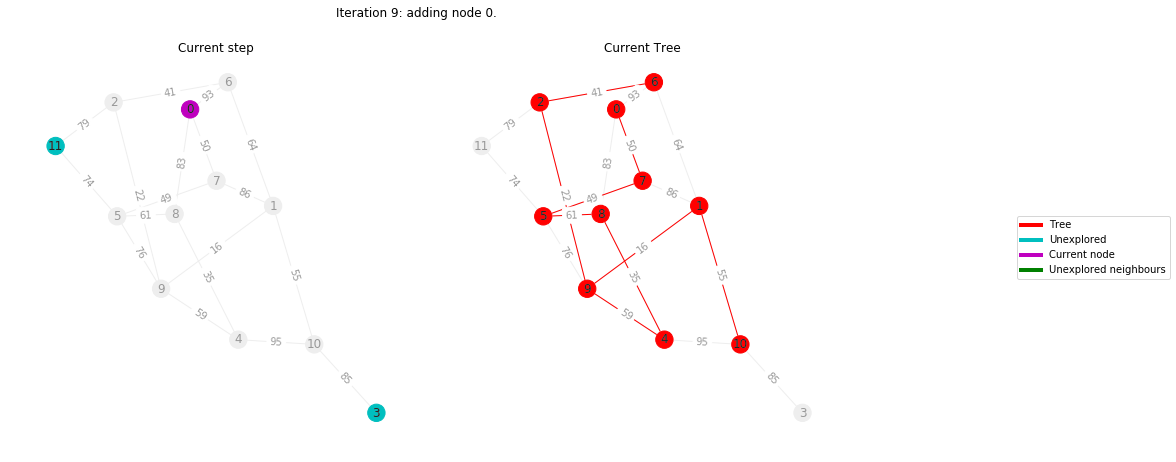

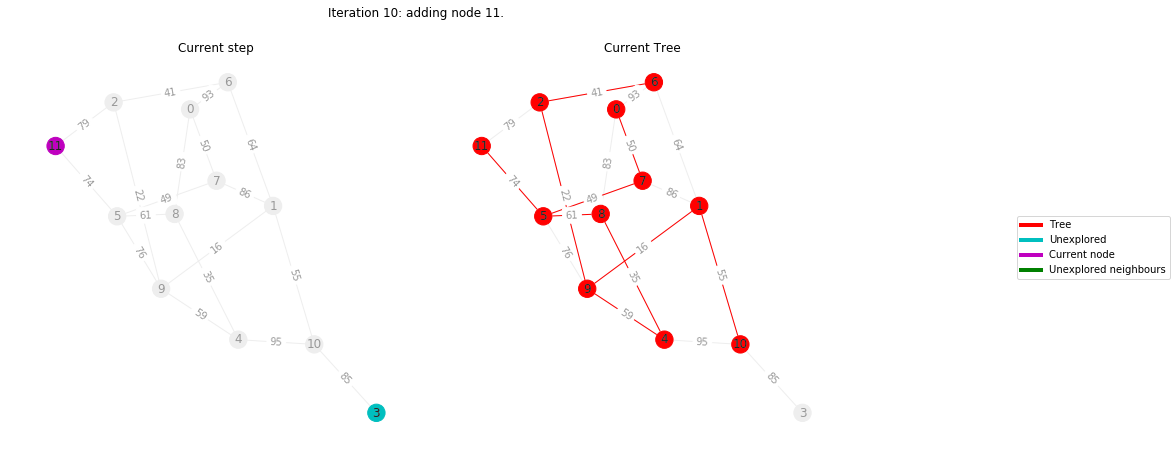

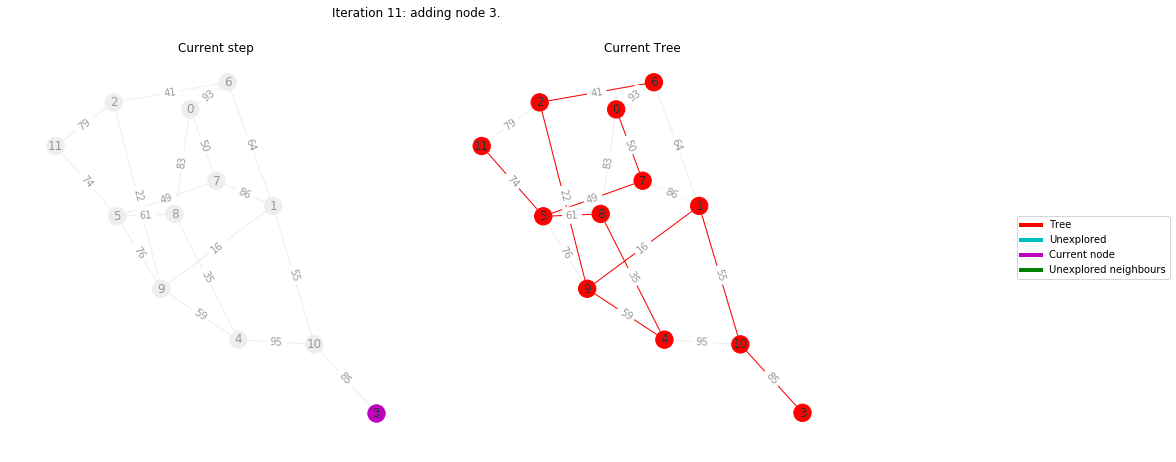

In [7]:
GraphicalPrimTree(G, root).run()